In [ ]:
import os

cache_dir ='/scratch/hakeem.at/Queryable-Shared-Reference-Repository/notebooks/pretrained_models'

os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HUGGINGFACE_HUB_CACHE'] = cache_dir

import json
import random
from tqdm.auto import tqdm
import pandas as pd

import torch
from vllm import LLM, SamplingParams

seed = 42
random.seed(seed)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import Faithfulness, ResponseRelevancy, LLMContextRecall, LLMContextPrecisionWithReference
from ragas import evaluate, EvaluationDataset, SingleTurnSample
from ragas.run_config import RunConfig

In [ ]:
embeddings = LangchainEmbeddingsWrapper(
    HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", cache_folder=cache_dir
    )
)

In [ ]:
for var in ['http_proxy', 'https_proxy', 'ftp_proxy', 'HTTP_PROXY', 'HTTPS_PROXY', 'FTP_PROXY']:
    os.environ.pop(var, None)

In [ ]:
VLLM_URL = "http://localhost:8000/v1"
MODEL = "Qwen/Qwen2.5-72B-Instruct-AWQ"#"nvidia/Llama-3.3-70B-Instruct-FP8"

evaluator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model=MODEL,
        openai_api_key="not-needed",
        openai_api_base=VLLM_URL,
        max_tokens=1024,
        temperature=0,
    )
)

In [ ]:
evaluator_llm.langchain_llm.invoke("Say hello")

In [ ]:
with open("responses_qwen3_vl_8b_1.json", "r") as f:
    response_data = json.load(f)
print(f"Loaded {len(response_data)} responses")

In [ ]:
metrics = [
    Faithfulness(llm=evaluator_llm),
    ResponseRelevancy(llm=evaluator_llm, embeddings=embeddings, strictness=1),
    # LLMContextPrecisionWithReference(llm=evaluator_llm),
    # LLMContextRecall(llm=evaluator_llm)
]

In [ ]:
samples = []

for item in response_data:
    contexts = item.get('retrieved_docs',[])[:3] or [item.get('context', '')]
    samples.append(
        SingleTurnSample(
        user_input = item.get('question'),
        retrieved_contexts = contexts,
        response = item.get('response', "I don't know"),
        reference = item.get('excerpt', '')
        )
    )
print(f"Valid samples: {len(samples)}")

In [ ]:
eval_dataset = EvaluationDataset(samples=samples)
eval_dataset= eval_dataset[:250]

In [ ]:
run_config = RunConfig(
    timeout=900,    
    max_retries=30,    
    max_wait=1,      
    max_workers=128,
)
results = evaluate(dataset = eval_dataset,
         metrics = metrics,
         show_progress=True,
         run_config=run_config,
)

In [ ]:
df = results.to_pandas()
df.head()

In [ ]:
metric_cols = [m.name for m in metrics if m.name in df.columns]
print("\n=== RESULTS BY MODEL ===")
print(df[metric_cols].mean().round(4))

df.to_csv("ragas_evaluation_results_qwen3_8b_3.csv", index=False)

In [ ]:
metric_cols = [m.name for m in metrics if m.name in df.columns]
print("\n=== RESULTS BY MODEL ===")
print(df[metric_cols].mean().round(4))
df.to_csv("ragas_evaluation_results_llama_3.csv", index=False)

In [ ]:
metric_cols = [m.name for m in metrics if m.name in df.columns]
print("\n=== RESULTS BY MODEL ===")
print(df[metric_cols].mean().round(4))
df.to_csv("ragas_evaluation_results_qwen3_vl_8b_3.csv", index=False)

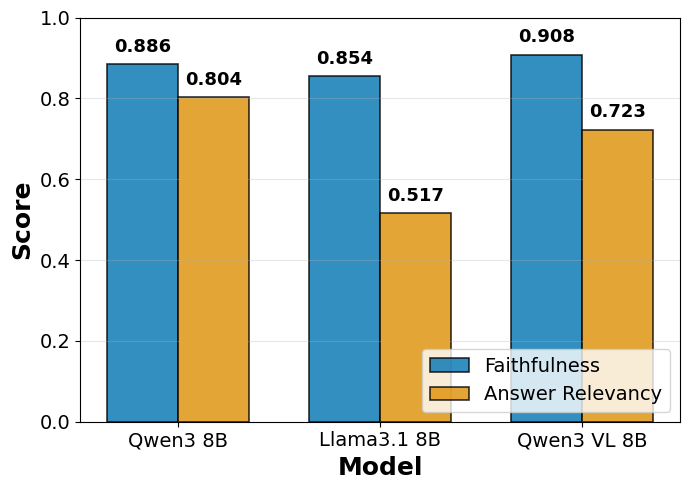

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette("colorblind")

models = ['Qwen3 8B', 'Llama3.1 8B', 'Qwen3 VL 8B']
faithfulness = [0.8858, 0.8541, 0.9083]
answer_relevancy = [0.8043, 0.5168, 0.7229]

colors = ['#0173B2', '#DE8F05']

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))

bars1 = ax.bar(x - width/2, faithfulness, width, label='Faithfulness', 
               color=colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars2 = ax.bar(x + width/2, answer_relevancy, width, label='Answer Relevancy', 
               color=colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax.set_ylabel('Score', fontsize=18, fontweight='bold')
ax.set_xlabel('Model', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.set_ylim(0, 1.0)
ax.legend(fontsize=14, loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='y', labelsize=14)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('ragas_comparison.png', dpi=300, bbox_inches='tight')
plt.show()